# IST707 Final Project
### Nadia Paquin

# Loading & Cleaning Data

In [98]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [79]:
# Loading local files (downloaded from kaggle)
data_cancer = pd.read_csv('archive/actual.csv')
data_test = pd.read_csv('archive/data_set_ALL_AML_independent.csv')
data = pd.read_csv('archive/data_set_ALL_AML_train.csv')

In [122]:
# Peak at the raw data
data.head()

,Gene Description,Gene Accession Number,1,2,3,4,5,6,7,8,...,35,36,37,38,28,29,30,31,32,33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,-139,-76,-135,-106,-138,-72,-413,...,7,-213,-25,-72,-4,15,-318,-32,-124,-135
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,-73,-49,-114,-125,-85,-144,-260,...,-100,-252,-20,-139,-116,-114,-192,-49,-79,-186
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,-1,-307,265,-76,215,238,7,...,-57,136,124,-1,-125,2,-95,49,-37,-70
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,283,309,12,168,71,55,-2,...,132,318,325,392,241,193,312,230,330,337
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,-264,-376,-419,-230,-272,-399,-541,...,-377,-209,-396,-324,-191,-51,-139,-367,-188,-407


In [81]:
# Investigating the call column. Does the it mean anything? And is the data all the same?
data[(data['call'] != 'A') & (data['call'] !='P')].head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
334,Renal Na+-dependent phosphate cotransporter,D28532_at,352,M,102,A,240,A,112,A,...,-5,A,230,A,105,A,183,A,184,A
341,HYPOTHETICAL MYELOID CELL LINE PROTEIN 3,D29642_at,438,M,658,P,269,A,807,P,...,179,P,289,A,264,A,691,P,79,A
405,KIAA0079 gene,D38555_at,338,M,413,P,-157,A,387,P,...,205,A,162,P,112,A,32,A,-131,A
419,RanBP2 (Ran-binding protein 2),D42063_at,104,M,227,M,166,A,6,A,...,127,P,193,A,70,P,115,A,204,A
520,KIAA0146 gene; partial cds,D63480_at,164,M,151,P,144,A,252,P,...,37,A,142,A,151,A,219,A,44,A


In [82]:
# Clean Train Set

# Remove call columns
train_keepers = [col for col in data.columns if "call" not in col]
data = data[train_keepers]

# Transposing data
data_transpose = data.transpose().copy()
data_transpose = data_transpose.drop('Gene Description')
data_transpose.columns = data_transpose.iloc[0]
data_transpose = data_transpose.drop('Gene Accession Number')
data_transpose.index.name = 'patient_number'
data_transpose.reset_index(inplace=True)
data_transpose['patient_number']=data_transpose['patient_number'].astype(int)

# Merging the training data with cancer status, renaming our training set back to train_set
patient_cancer = pd.merge(data_transpose, data_cancer, left_on = 'patient_number', right_on = 'patient',
                          how = 'left')
patient_cancer= patient_cancer.drop(columns =['patient'])
train_set = patient_cancer.copy()

In [83]:
# Clean Test Set

# Remove call columns
test_keepers = [col for col in data_test.columns if "call" not in col]
data_test = data_test[test_keepers]

# Transposing the test set
data_transpose = data_test.transpose().copy()
data_transpose = data_transpose.drop('Gene Description')
data_transpose.columns = data_transpose.iloc[0]
data_transpose = data_transpose.drop('Gene Accession Number')
data_transpose.index.name = 'patient_number'
data_transpose.reset_index(inplace=True)
data_transpose['patient_number']=data_transpose['patient_number'].astype(int)

# Merging the training data with cancer status, renaming our training set back to train_set
patient_cancer = pd.merge(data_transpose, data_cancer, left_on = 'patient_number', right_on = 'patient',
                          how = 'left')
patient_cancer= patient_cancer.drop(columns =['patient'])
test_set = patient_cancer.copy()

# Heat Map

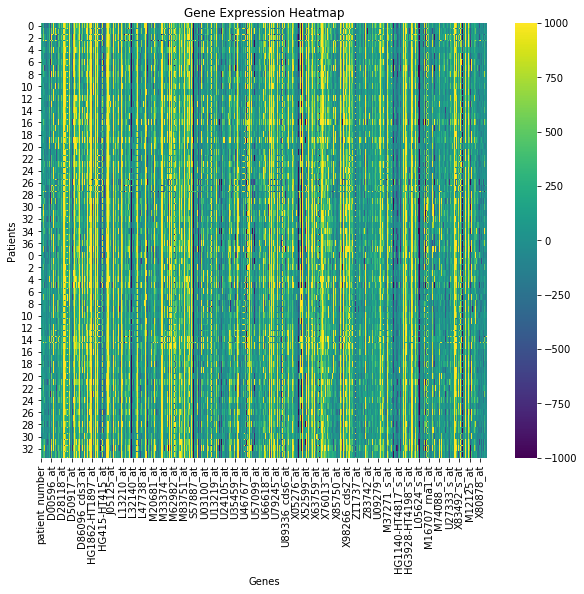

In [103]:
# Creating a df suitable for a heatmap
patients = pd.concat([train_set, test_set], axis=0) # Patients dataframe to include all 72 patients
patients.sort_values(by='cancer', ascending=True) # ALL will be top half, AML will be bottom half
patients = patients.drop(columns=['cancer']) # Dropping cancer col
patients = patients.apply(pd.to_numeric) # Ensuring numeric data

# Heatmap creation
plt.figure(figsize=(10, 8))
sns.heatmap(patients, cmap='viridis', vmin=-1000, vmax=1000)
plt.xlabel('Genes')
plt.ylabel('Patients')
plt.title('Gene Expression Heatmap')
plt.show()

# Models

In [84]:
# Dividing X and Y test and train
x_train = train_set.iloc[:, 1:-1]
y_train = train_set.iloc[:, -1]
x_test = test_set.iloc[:, 1:-1]
y_test = test_set.iloc[:, -1]

# Principle Component Analysis

22 features explain around 90% of the variance. Only those principal components are needed to capture 90% of the information in the original dataset. From 7129 features to 22, not too bad.


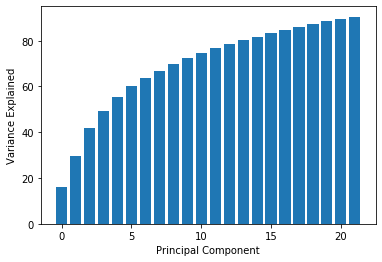

In [125]:
# PCA evaluation
pca = PCA()
pca.fit_transform(x_train)

total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1
    
print(k, " features explain around 90% of the variance. Only those principal components are needed to capture 90% of the information in the original dataset. From 7129 features to ", k, ", not too bad.", sep='')

pca = PCA(n_components=k)
x_train.pca = pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# Support Vector Machine

Best Parameters:
 {'C': 0.1, 'decision_function_shape': 'ovo', 'gamma': 1, 'kernel': 'linear'}
SVM accuracy: 0.941


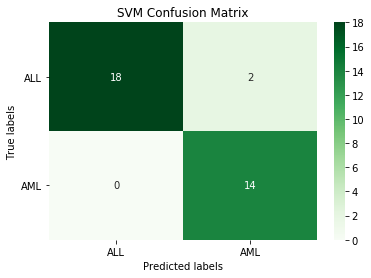

In [107]:
# Gridsearch for optimal parameters
svm_param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10], "kernel": ["linear", "rbf", "poly"], "decision_function_shape" : ["ovo", "ovr"]} 
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3) # Creating SVM grid search classifier
svm_grid.fit(x_train_pca, y_train) # Train the classifier
print("Best Parameters:\n", svm_grid.best_params_) 

# Select best svc
best_svc = svm_grid.best_estimator_

# Make predictions 
svm_pred = best_svc.predict(x_test_pca)

# Evaluate model
print('SVM accuracy:', round(accuracy_score(y_test, svm_pred), 3))

# Confusion Matrix SVM
cm_svm = confusion_matrix(y_test, svm_pred)
ax = plt.subplot()
sns.heatmap(cm_svm, annot=True, ax = ax, fmt='g', cmap='Greens') 
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('SVM Confusion Matrix') 
labels = ['ALL', 'AML'] 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

# K-Means

K-means accuracy: 0.853


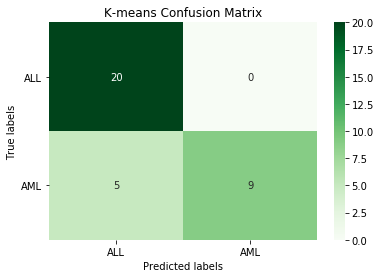

In [131]:
# Fitting model
np.random.seed(42)
kmeans = KMeans(n_clusters=2) # 2 clusters for 2 groups
kmeans.fit(x_train)
y_test = y_test.replace({'ALL':0,'AML':1}) 

# Make predictions
km_preds = kmeans.predict(x_test)

# Confusion Matrix Plot
cm_km = confusion_matrix(y_test, km_preds)
ax = plt.subplot()
sns.heatmap(cm_km, annot=True, ax = ax, fmt='g', cmap='Greens') 
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('K-means Confusion Matrix') 
labels = ['ALL', 'AML'] 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

# Evaluate model
print('K-means accuracy:', round(accuracy_score(y_test, km_preds), 3))

# Logistic Regression

Best Parameters:
 {'C': 1, 'penalty': 'l1'}
Log Accuracy: 1.0


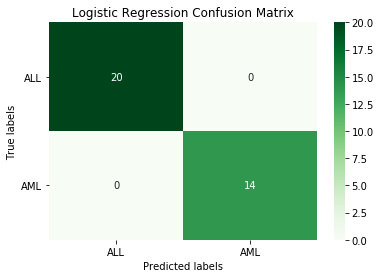

In [95]:
# Gridsearch for optimal parameters
log_grid = {'C': [1e-03, 1e-2, 1e-1, 1, 10], 
                 'penalty': ['l1', 'l2']}
log_estimator = LogisticRegression(solver='liblinear')
log_model = GridSearchCV(estimator=log_estimator, 
                  param_grid=log_grid, 
                  cv=3,
                  scoring='accuracy')

# Fitting model
log_model.fit(x_train, y_train)
print("Best Parameters:\n", log_model.best_params_)
best_log = log_model.best_estimator_

# Make predictions
log_preds = best_log.predict(x_test)

# Evaluate model
print("Log Accuracy:", round(accuracy_score(y_test, log_preds), 3))

# Confusion matrix plot
cm_km = confusion_matrix(y_test, log_preds)
ax = plt.subplot()
sns.heatmap(cm_km, annot=True, ax = ax, fmt='g', cmap='Greens') 
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Logistic Regression Confusion Matrix') 
labels = ['ALL', 'AML'] 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

# Naive Bayes

Naive Bayes accuracy: 0.912


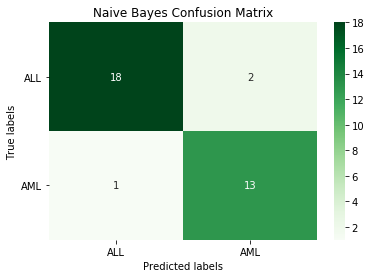

In [97]:
# Create a Gaussian classifier
nb_model = GaussianNB()
nb_model.fit(x_train, y_train)

# Make predictions
nb_pred = nb_model.predict(x_test)

# Evaluate model
print('Naive Bayes accuracy:', round(accuracy_score(y_test, nb_pred), 3))

# Confusion matrix plot
cm_nb =  confusion_matrix(y_test, nb_pred)
ax = plt.subplot()
sns.heatmap(cm_nb, annot=True, ax = ax, fmt='g', cmap='Greens') 
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Naive Bayes Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

# Random Forest

Best Parameters:
 {'bootstrap': False, 'max_features': 0.6, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 60}
Random Forest accuracy: 0.912


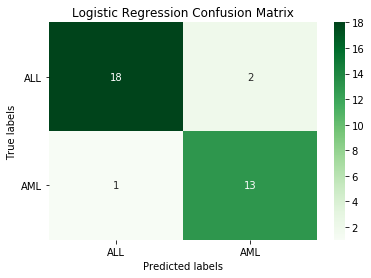

In [99]:
# Gridsearch for optimal parameters
rf_param_grid = {'bootstrap': [False, True],
         'n_estimators': [60, 70, 80, 90, 100],
         'max_features': [0.6, 0.65, 0.7, 0.75, 0.8],
         'min_samples_leaf': [8, 10, 12, 14],
         'min_samples_split': [3, 5, 7]
        }
rf_estimator = RandomForestClassifier(random_state=0)
rf_model = GridSearchCV(estimator=rf_estimator, param_grid=rf_param_grid, cv=3, scoring='accuracy')

# Fitting model
rf_model.fit(x_train, y_train)
print("Best Parameters:\n", rf_model.best_params_)
rf_model_best = rf_model.best_estimator_

# Make predictions
rf_pred = rf_model_best.predict(x_test)

# Evaluate model
print('Random Forest accuracy:', round(accuracy_score(y_test, rf_pred), 3))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_pred)
ax = plt.subplot()
sns.heatmap(cm_rf, annot=True, ax = ax, fmt='g', cmap='Greens') 
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Random Forest Confusion Matrix') 
labels = ['ALL', 'AML'] 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);